%md
# Sentiment model

### Project Group #27
#### Clara Richter, Elise Rust, Yujia Jin
##### ANLY 502
##### Project Deliverable #2
#####Nov 22, 2022

######Adapted from Lab 9 Setup

In [0]:
# Install PySpark and Spark NLP
! pip install -q pyspark==3.1.2 spark-nlp

In [0]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
import seaborn as sns

In [0]:
spark = sparknlp.start()

#### Pre-trained model:

In [0]:
MODEL_NAME='sentimentdl_use_twitter'

In [0]:
## Read in comments and submissions data
com_all=spark.read.parquet("/tmp/out/com_kpis.parquet")
sub_all=spark.read.parquet("/tmp/out/sub_kpis.parquet")

In [0]:
com_all.show(5)

+-------------+--------------------+-------+-----+---------+-------------------+----+-----+----+-----------+--------------+------------+----------------+-------------+-------------+---------------+-----------+-------+----------+--------+-------------------+
|       author|                body|link_id|score|subreddit|               time|year|month|hour|time_of_day|comment_length|dummy_police|dummy_healthcare|dummy_climate|dummy_economy|dummy_education|dummy_trump|    CPI|Unemp_Rate|     DOW|               date|
+-------------+--------------------+-------+-----+---------+-------------------+----+-----+----+-----------+--------------+------------+----------------+-------------+-------------+---------------+-----------+-------+----------+--------+-------------------+
| ThatGuy_Gary|Geez.\n\nIf they ...| mkgo9d|    2|democrats|2021-04-05 18:57:57|2021|    4|  18|  Afternoon|           108|       false|           false|        false|        false|          false|      false|266.727|       6.

In [0]:
# get list of text
text_list = list(com_all.select('body').toPandas()['body'])

In [0]:
# Get list of titles
titles_list = list(sub_all.select('title').toPandas()['title'])

#### Define Spark NLP pipleline:

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name=MODEL_NAME, lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


#### Run the pipeline:

###### First, for our subreddit comments and then for our subreddit titles.

We are examing these two dataframes separately as we believe they contain different types of text data and connotations. The titles of posts in the political subreddits are largely headlines from newspaper articles, and thus examining the headlines reflects the sentiment/polarization of journalists and large newspapers in the united states across different political factions. The comments of posts in the political subreddits reflect how average Reddit users and average American citizens may be engaging with various political comments. Understanding how positively or negatively different commentators on the Republican vs Democratic subreddits are engaging may reflect what types of conversations being fostered within each party's base and how heated discussions may be getting.

#### 1) Comments

In [0]:
empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

df_new = spark.createDataFrame(pd.DataFrame({"text":text_list}))
result = pipelineModel.transform(df_new)

In [0]:
result.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|            document| sentence_embeddings|           sentiment|
+--------------------+--------------------+--------------------+--------------------+
|Geez.\n\nIf they ...|[{document, 0, 10...|[{sentence_embedd...|[{category, 0, 10...|
|Wow! I didn't kno...|[{document, 0, 42...|[{sentence_embedd...|[{category, 0, 42...|
|We need more than...|[{document, 0, 42...|[{sentence_embedd...|[{category, 0, 42...|
|The Republican pa...|[{document, 0, 18...|[{sentence_embedd...|[{category, 0, 18...|
|It is their own u...|[{document, 0, 81...|[{sentence_embedd...|[{category, 0, 81...|
|All they care abo...|[{document, 0, 66...|[{sentence_embedd...|[{category, 0, 66...|
|He needs a covid ...|[{document, 0, 28...|[{sentence_embedd...|[{category, 0, 28...|
|In the scholar su...|[{document, 0, 18...|[{sentence_embedd...|[{category, 0, 18...|
|"If at first you ...|[{document, 0, 44...|[{sentence_

In [0]:
result2 = result.select('text', F.explode('sentiment.result'))
result2.show(5)

+--------------------+--------+
|                text|     col|
+--------------------+--------+
|Geez.\n\nIf they ...|negative|
|Wow! I didn't kno...|positive|
|We need more than...|positive|
|The Republican pa...|negative|
|It is their own u...|positive|
+--------------------+--------+
only showing top 5 rows



##### Add sentiment column to main dataframe:

In [0]:
# sentiment column
df_sentiment = result2.select('col')
df_sentiment = df_sentiment.withColumnRenamed("col","sentiment")
df_sentiment.show(10)

+---------+
|sentiment|
+---------+
| negative|
| positive|
| positive|
| negative|
| positive|
| positive|
| positive|
| positive|
| positive|
| positive|
+---------+
only showing top 10 rows



In [0]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window

#add 'sequential' index and join both dataframe to get the final result
a = com_all.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
b = df_sentiment.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

comments_sentiment = a.join(b, a.row_idx == b.row_idx).\
             drop("row_idx")
comments_sentiment.show()

+--------------------+--------------------+-------+-----+----------+-------------------+----+-----+----+-----------+--------------+------------+----------------+-------------+-------------+---------------+-----------+-------+----------+--------+-------------------+---------+
|              author|                body|link_id|score| subreddit|               time|year|month|hour|time_of_day|comment_length|dummy_police|dummy_healthcare|dummy_climate|dummy_economy|dummy_education|dummy_trump|    CPI|Unemp_Rate|     DOW|               date|sentiment|
+--------------------+--------------------+-------+-----+----------+-------------------+----+-----+----+-----------+--------------+------------+----------------+-------------+-------------+---------------+-----------+-------+----------+--------+-------------------+---------+
|        ThatGuy_Gary|Geez.\n\nIf they ...| mkgo9d|    2| democrats|2021-04-05 18:57:57|2021|    4|  18|  Afternoon|           108|       false|           false|        fal

#### 2) Titles

Repeat the steps above

In [0]:
empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

df_new = spark.createDataFrame(pd.DataFrame({"text":titles_list}))

result = pipelineModel.transform(df_new)

In [0]:
result.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|            document| sentence_embeddings|           sentiment|
+--------------------+--------------------+--------------------+--------------------+
|Nancy Pelosi's ho...|[{document, 0, 13...|[{sentence_embedd...|[{category, 0, 13...|
|"This Whole Thing...|[{document, 0, 98...|[{sentence_embedd...|[{category, 0, 98...|
|Chaos on Capitol ...|[{document, 0, 72...|[{sentence_embedd...|[{category, 0, 72...|
|Right-wing extrem...|[{document, 0, 27...|[{sentence_embedd...|[{category, 0, 27...|
|Here are six vide...|[{document, 0, 11...|[{sentence_embedd...|[{category, 0, 11...|
|Goodbye Trump, He...|[{document, 0, 35...|[{sentence_embedd...|[{category, 0, 35...|
|Don’t tease, Donn...|[{document, 0, 64...|[{sentence_embedd...|[{category, 0, 64...|
|https://2021tees....|[{document, 0, 45...|[{sentence_embedd...|[{category, 0, 45...|
|Democrats plans i...|[{document, 0, 79...|[{sentence_

In [0]:
result2 = result.select('text', F.explode('sentiment.result'))
result2.show(5)

+--------------------+--------+
|                text|     col|
+--------------------+--------+
|Nancy Pelosi's ho...|negative|
|"This Whole Thing...|negative|
|Chaos on Capitol ...|negative|
|Right-wing extrem...|negative|
|Here are six vide...|negative|
+--------------------+--------+
only showing top 5 rows



##### Add sentiment column to dataframe

In [0]:
# sentiment column
df_sentiment = result2.select('col')
df_sentiment = df_sentiment.withColumnRenamed("col","sentiment")
df_sentiment.show(10)

+---------+
|sentiment|
+---------+
| negative|
| negative|
| negative|
| negative|
| negative|
| negative|
| negative|
|  neutral|
| negative|
| negative|
+---------+
only showing top 10 rows



In [0]:
#add 'sequential' index and join both dataframe to get the final result
a = sub_all.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
b = df_sentiment.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

titles_sentiment = a.join(b, a.row_idx == b.row_idx).\
             drop("row_idx")
titles_sentiment.show()

+---------+--------------------+-----+------------+------+-------------------+----+-----+----+-----------+------------+-------------+------------+----------------+-------------+-------------+---------------+-----------+-----+----------+--------+-------------------+---------+
|subreddit|               title|score|num_comments|    id|               time|year|month|hour|time_of_day|title_length|election_year|dummy_police|dummy_healthcare|dummy_climate|dummy_economy|dummy_education|dummy_trump|  CPI|Unemp_Rate|     DOW|               date|sentiment|
+---------+--------------------+-----+------------+------+-------------------+----+-----+----+-----------+------------+-------------+------------+----------------+-------------+-------------+---------------+-----------+-----+----------+--------+-------------------+---------+
|democrats|Nancy Pelosi's ho...|    1|           1|kopbry|2021-01-02 02:58:53|2021|    1|   2|      Night|         132|        false|       false|           false|        f

#### Save data to DBFS:

In [0]:
## 1) Comments
comments_sentiment.write.parquet("/tmp/out/com_kpis_sent.parquet")

## 2) Submissions
titles_sentiment.write.parquet("/tmp/out/sub_kpis_sent.parquet")

### Exploring our Business Questions

As a refresher from last time, the basic NLP business questions we're interested in are:
1) Which subreddits produce the most/least negative discourse in their comments? In their titles?
2) Which topics are correlated to the highest rates of negative sentiment and/or polarization?
3) Do posts with positive, negative, or neutral sentiment receive the most engagement on Reddit?
4) How does the economy influence political sentiment? When KPIs like unemployment rate are high, how does that affect the types of media and comments that are commonly posted?

#### Summary tables and Graphs to address our business questions:

In [0]:
#### ONLY RUN ONCE: Change directory to root so that packages can load and tables/plots can be saved
import os

os.chdir('../../')

print(os.getcwd()) # Confirm the directory change was successful

/Workspace/Repos/er844@georgetown.edu/fall-2022-reddit-big-data-project-project-group-27


In [0]:
import pandas as pd

## Read in sentment dataframes again
## 1) Comments
comments_sentiment = spark.read.parquet("dbfs:/tmp/out/com_kpis_sent.parquet")

## 2) Submissions
titles_sentiment = spark.read.parquet("dbfs:/tmp/out/sub_kpis_sent.parquet")

##### Polarization Data and Plot

In [0]:
###### Generate "polarization" variable 
# Comments
polarization = comments_sentiment.groupBy("subreddit", "sentiment").count()
polarization = polarization.groupBy("subreddit").pivot("sentiment").sum("count")
polarization_com = polarization.withColumn("polarization_score", (polarization['positive']-polarization['negative'])).select('subreddit','polarization_score')

comments_sentiment = comments_sentiment.join(polarization_com, on="subreddit")
comments_sentiment.show()

# Submissions
polarization = titles_sentiment.groupBy("subreddit", "sentiment").count()
polarization = polarization.groupBy("subreddit").pivot("sentiment").sum("count")
polarization_sub = polarization.withColumn("polarization_score", (polarization['positive']-polarization['negative'])).select('subreddit','polarization_score')

titles_sentiment = titles_sentiment.join(polarization_sub, on="subreddit")

+----------+--------------------+--------------------+-------+-----+-------------------+----+-----+----+-----------+--------------+------------+----------------+-------------+-------------+---------------+-----------+-------+----------+--------+-------------------+---------+------------------+
| subreddit|              author|                body|link_id|score|               time|year|month|hour|time_of_day|comment_length|dummy_police|dummy_healthcare|dummy_climate|dummy_economy|dummy_education|dummy_trump|    CPI|Unemp_Rate|     DOW|               date|sentiment|polarization_score|
+----------+--------------------+--------------------+-------+-----+-------------------+----+-----+----+-----------+--------------+------------+----------------+-------------+-------------+---------------+-----------+-------+----------+--------+-------------------+---------+------------------+
|Republican|Silver_BoogieBoarder|It's hard to be a...| mi0aqa|    1|2021-04-02 00:28:50|2021|    4|   0|       null

In [0]:
polarization_com.show()

+----------+------------------+
| subreddit|polarization_score|
+----------+------------------+
| democrats|             -6507|
|Republican|               -31|
|  politics|           -108019|
+----------+------------------+



In [0]:
# Polarization scores --> how many more "negative" titles there were on each subreddit
polarization_sub.show()

+----------+------------------+
| subreddit|polarization_score|
+----------+------------------+
| democrats|             -1743|
|  politics|             -5958|
|Republican|             -3864|
+----------+------------------+



In [0]:
# Polarization scores --> how many more "positive" titles there were on each subreddit
polarization_com_pd = polarization_com.toPandas()
polarization_com_pd

,subreddit,polarization_score
0,democrats,-6507
1,Republican,-31
2,politics,-108019


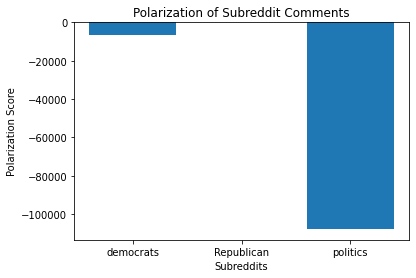

In [0]:
import numpy as np
import matplotlib.pyplot as plt

plt.bar(polarization_com_pd["subreddit"], polarization_com_pd['polarization_score'])
plt.xlabel("Subreddits")
plt.ylabel('Polarization Score')
plt.title("Polarization of Subreddit Comments")
plt.show()
#plt.savefig('data/plots/polarization_comments.png', bbox_inches='tight')# Save to data/plots folder

In [0]:
polarization_sub_pd = polarization_sub.toPandas()
polarization_sub_pd

,subreddit,polarization_score
0,democrats,-1743
1,politics,-5958
2,Republican,-3864


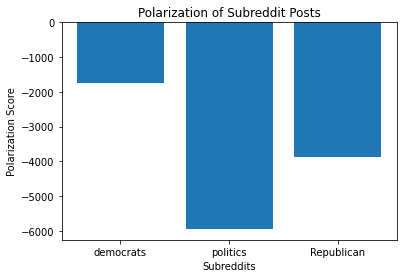

In [0]:
plt.bar(polarization_sub_pd["subreddit"], polarization_sub_pd['polarization_score'])
plt.xlabel("Subreddits")
plt.ylabel('Polarization Score')
plt.title("Polarization of Subreddit Posts")
plt.show()
#plt.savefig('data/plots/polarization_subreddit.png', bbox_inches='tight')# Save to data/plots folder

##### Which subreddits produce the most/least negative discourse in their comments? In their titles?

In [0]:
subreddits_sent_df = titles_sentiment.groupBy("subreddit","sentiment").count().toPandas()
subreddits_sent_df

,subreddit,sentiment,count
0,democrats,negative,7385
1,democrats,neutral,534
2,democrats,positive,5642
3,politics,positive,4151
4,politics,negative,10109
5,politics,neutral,455
6,Republican,negative,8556
7,Republican,positive,4692
8,Republican,neutral,490


Out[31]: []

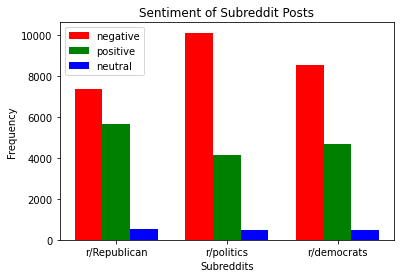

In [0]:
N = 3
ind = np.arange(N) 
width = 0.25
  
xvals = subreddits_sent_df.loc[subreddits_sent_df['sentiment'] == 'negative']
bar1 = plt.bar(ind, xvals['count'], width, color = 'r')

yvals = subreddits_sent_df.loc[subreddits_sent_df['sentiment'] == 'positive']
bar2 = plt.bar(ind+width, yvals['count'], width, color = 'g')

zvals = subreddits_sent_df.loc[subreddits_sent_df['sentiment'] == 'neutral']
bar3 = plt.bar(ind+width*2, zvals['count'], width, color = 'b')

plt.xlabel("Subreddits")
plt.ylabel('Frequency')
plt.title("Sentiment of Subreddit Posts")
  
plt.xticks(ind+width,['r/Republican', 'r/politics', 'r/democrats'])
plt.legend( (bar1, bar2, bar3), ('negative', 'positive', 'neutral') )
plt.plot()
#plt.savefig('data/plots/sent_subreddits.png', bbox_inches='tight')# Save to data/plots folder

In [0]:
subreddits_sent_com_df = comments_sentiment.groupBy("subreddit","sentiment").count().toPandas()
subreddits_sent_com_df

,subreddit,sentiment,count
0,Republican,negative,19430
1,Republican,positive,19399
2,Republican,neutral,1881
3,democrats,negative,24818
4,democrats,positive,18311
5,democrats,neutral,2280
6,politics,positive,115353
7,politics,negative,223372
8,politics,neutral,16022


In [0]:
comments_sentiment.show()

+----------+--------------------+--------------------+-------+-----+-------------------+----+-----+----+-----------+--------------+------------+----------------+-------------+-------------+---------------+-----------+-------+----------+--------+-------------------+---------+------------------+
| subreddit|              author|                body|link_id|score|               time|year|month|hour|time_of_day|comment_length|dummy_police|dummy_healthcare|dummy_climate|dummy_economy|dummy_education|dummy_trump|    CPI|Unemp_Rate|     DOW|               date|sentiment|polarization_score|
+----------+--------------------+--------------------+-------+-----+-------------------+----+-----+----+-----------+--------------+------------+----------------+-------------+-------------+---------------+-----------+-------+----------+--------+-------------------+---------+------------------+
|Republican|Silver_BoogieBoarder|It's hard to be a...| mi0aqa|    1|2021-04-02 00:28:50|2021|    4|   0|       null

Out[34]: <matplotlib.legend.Legend at 0x7ff70489d6a0>

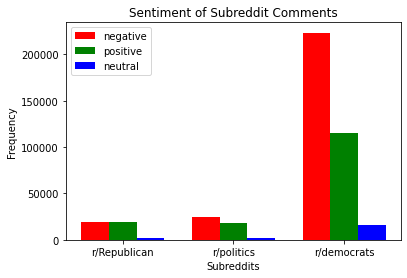

In [0]:
N = 3
ind = np.arange(N) 
width = 0.25
  
xvals = subreddits_sent_com_df.loc[subreddits_sent_com_df['sentiment'] == 'negative']
bar1 = plt.bar(ind, xvals['count'], width, color = 'r')

yvals = subreddits_sent_com_df.loc[subreddits_sent_com_df['sentiment'] == 'positive']
bar2 = plt.bar(ind+width, yvals['count'], width, color = 'g')

zvals = subreddits_sent_com_df.loc[subreddits_sent_com_df['sentiment'] == 'neutral']
bar3 = plt.bar(ind+width*2, zvals['count'], width, color = 'b')

plt.xlabel("Subreddits")
plt.ylabel('Frequency')
plt.title("Sentiment of Subreddit Comments")
  
plt.xticks(ind+width,['r/Republican', 'r/politics', 'r/democrats'])
plt.legend( (bar1, bar2, bar3), ('negative', 'positive', 'neutral') )
#plt.savefig('data/plots/sent_subreddits_com.png', bbox_inches='tight')# Save to data/plots folder

##### Do posts with positive, negative, or neutral sentiment receive the most engagement on Reddit?

In [0]:
titles_sentiment.groupBy("num_comments","sentiment").count().show()

+------------+---------+-----+
|num_comments|sentiment|count|
+------------+---------+-----+
|           1| negative| 6174|
|           0| negative| 4464|
|          23| negative|  126|
|           0|  neutral|  381|
|           3| positive|  703|
|           2| positive| 1323|
|           1|  neutral|  400|
|          11| positive|  112|
|           1| positive| 3976|
|           5| negative|  800|
|           2| negative| 2848|
|           6| negative|  662|
|           7| negative|  519|
|           4| negative| 1038|
|           3| negative| 1480|
|           0| positive| 3814|
|           3|  neutral|   64|
|          63| negative|   24|
|          16| positive|   93|
|         199| positive|    2|
+------------+---------+-----+
only showing top 20 rows



In [0]:
import pandas as pd
num_com_sent_df = titles_sentiment.groupBy("num_comments","sentiment").count().toPandas()
score_sent_df = titles_sentiment.groupBy("score","sentiment").count().toPandas()

In [0]:
num_com_sent_df

,num_comments,sentiment,count
0,1,negative,6174
1,0,negative,4464
2,23,negative,126
3,0,neutral,381
4,3,positive,703
...,...,...,...
1180,350,neutral,1
1181,408,positive,1
1182,203,positive,1
1183,178,positive,1


In [0]:
score_sent_df

,score,sentiment,count
0,1,negative,7933
1,53,negative,61
2,6,negative,476
3,2,neutral,54
4,0,negative,1636
...,...,...,...
3462,1406,positive,1
3463,2323,positive,1
3464,2306,positive,1
3465,5920,negative,1


In [0]:
bins = [-1, 5, 10, 20, 50, 100, np.inf]
names = ['<5', '5-10', '10-20', '20-50', '50-100','100+']

score_sent_df['scoreRange'] = pd.cut(score_sent_df['score'], bins, labels=names)
score_sent_df

,score,sentiment,count,scoreRange
0,1,negative,7933,<5
1,53,negative,61,50-100
2,6,negative,476,5-10
3,2,neutral,54,<5
4,0,negative,1636,<5
...,...,...,...,...
3462,1406,positive,1,100+
3463,2323,positive,1,100+
3464,2306,positive,1,100+
3465,5920,negative,1,100+


In [0]:
score_sent_df_gb = score_sent_df.groupby(['scoreRange','sentiment'])['count'].sum().to_frame().reset_index()
score_sent_df_gb.to_csv("data/csv/nlp/table1.csv") # Save to data/csvs
score_sent_df_gb

,scoreRange,sentiment,count
0,<5,negative,12246
1,<5,neutral,850
2,<5,positive,8446
3,5-10,negative,2146
4,5-10,neutral,125
5,5-10,positive,1041
6,10-20,negative,2399
7,10-20,neutral,90
8,10-20,positive,1133
9,20-50,negative,2695


In [0]:
num_com_sent_df['comRange'] = pd.cut(num_com_sent_df['num_comments'], bins, labels=names)
num_com_sent_df

,num_comments,sentiment,count,comRange
0,1,negative,6174,<5
1,0,negative,4464,<5
2,23,negative,126,20-50
3,0,neutral,381,<5
4,3,positive,703,<5
...,...,...,...,...
1180,350,neutral,1,100+
1181,408,positive,1,100+
1182,203,positive,1,100+
1183,178,positive,1,100+


In [0]:
num_com_sent_df_gb = num_com_sent_df.groupby(['comRange','sentiment'])['count'].sum().to_frame().reset_index()
num_com_sent_df_gb

,comRange,sentiment,count
0,<5,negative,16804
1,<5,neutral,1068
2,<5,positive,10611
3,5-10,negative,2380
4,5-10,neutral,100
5,5-10,positive,1012
6,10-20,negative,2115
7,10-20,neutral,95
8,10-20,positive,917
9,20-50,negative,2288


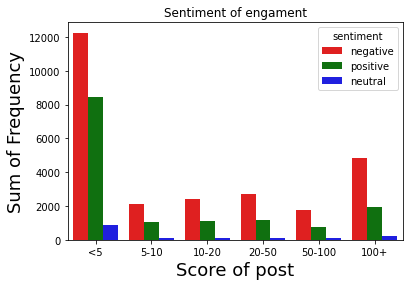

In [0]:
import seaborn as sns
sns.barplot(data = score_sent_df_gb, 
                x = 'scoreRange', 
                y = 'count', 
                hue = 'sentiment',
                hue_order = ['negative', 'positive', 'neutral'],
               palette=['red','green','blue'])
FS = 18
plt.xlabel('Score of post', fontsize=FS)
plt.ylabel('Sum of Frequency', fontsize=FS)
plt.title("Sentiment of engament")
plt.show()
#plt.savefig('data/plots/sent_score.png', bbox_inches='tight')# Save to data/plots folder

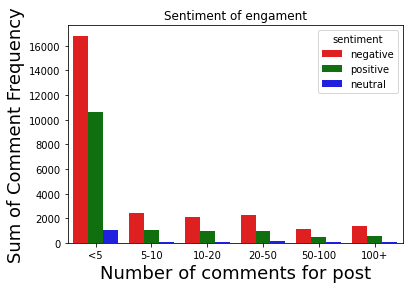

In [0]:
sns.barplot(data = num_com_sent_df_gb, 
                x = 'comRange', 
                y = 'count', 
                hue = 'sentiment',
                hue_order = ['negative', 'positive', 'neutral'],
               palette=['red','green','blue'])
FS = 18
plt.xlabel('Number of comments for post', fontsize=FS)
plt.ylabel('Sum of Comment Frequency', fontsize=FS)
plt.title("Sentiment of engament")
plt.show()
#plt.savefig('data/plots/sent_comments.png', bbox_inches='tight')# Save to data/plots folder

##### Which topics are correlated to the highest rates of negative sentiment and/or polarization?

In [0]:
comments_sentiment.groupBy("subreddit","dummy_police", "dummy_healthcare", "dummy_climate","dummy_economy","sentiment").count().show()

+----------+------------+----------------+-------------+-------------+---------+-----+
| subreddit|dummy_police|dummy_healthcare|dummy_climate|dummy_economy|sentiment|count|
+----------+------------+----------------+-------------+-------------+---------+-----+
|Republican|       false|           false|        false|        false| negative|17872|
|Republican|       false|           false|        false|        false| positive|18178|
|Republican|        true|           false|        false|        false| negative|  626|
|Republican|        true|           false|         true|         true| negative|    3|
|Republican|       false|            true|        false|        false| negative|  488|
|Republican|        true|           false|        false|        false| positive|  498|
|Republican|       false|           false|         true|        false| negative|   48|
|Republican|       false|           false|        false|        false|  neutral| 1778|
|Republican|       false|           false| 

In [0]:
comments_sentiment.groupBy("dummy_police","sentiment").count().show()

+------------+---------+------+
|dummy_police|sentiment| count|
+------------+---------+------+
|       false| negative|254462|
|       false| positive|147271|
|        true| negative| 13158|
|        true| positive|  5792|
|       false|  neutral| 19338|
|        true|  neutral|   845|
+------------+---------+------+



In [0]:
## Prepare data for plotting
com_df = comments_sentiment.toPandas()
com_df = com_df.melt(id_vars="sentiment", value_vars=["dummy_police", "dummy_healthcare", "dummy_climate", "dummy_economy"], var_name="topic")
com_df = com_df[com_df.value != False]

In [0]:
com_df = com_df.groupby(["sentiment", "topic"]).count()
com_df = com_df.reset_index(level=["sentiment", "topic"])

com_df

,sentiment,topic,value
0,negative,dummy_climate,1227
1,negative,dummy_economy,6353
2,negative,dummy_healthcare,8460
3,negative,dummy_police,13158
4,neutral,dummy_climate,100
5,neutral,dummy_economy,389
6,neutral,dummy_healthcare,535
7,neutral,dummy_police,845
8,positive,dummy_climate,755
9,positive,dummy_economy,3016


In [0]:
# Create summary table #2
table2 = com_df.pivot(index="topic", columns="sentiment", values="value")
table2 = table2.reset_index()
table2["% negative"] = (table2["negative"]/(table2["negative"]+table2["neutral"]+table2["positive"]))*100
table2["% positive"] = (table2["positive"]/(table2["negative"]+table2["neutral"]+table2["positive"]))*100
table2["topic"] = table2["topic"].str[6:]
table2.to_csv("data/csv/nlp/table2.csv") # save to Git
table2

sentiment,topic,negative,neutral,positive,% negative,% positive
0,climate,1227,100,755,58.933718,36.263208
1,economy,6353,389,3016,65.105554,30.907973
2,healthcare,8460,535,3906,65.576312,30.276723
3,police,13158,845,5792,66.471331,29.259914


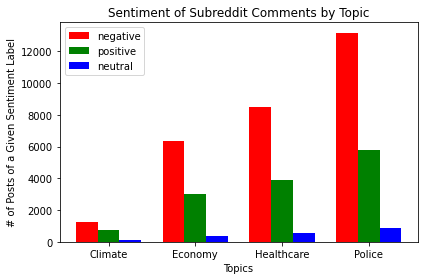

In [0]:
N = 4
ind = np.arange(N) 
width = 0.25
  
xvals = com_df.loc[com_df['sentiment'] == 'negative']
bar1 = plt.bar(ind, xvals['value'], width, color = 'r')

yvals = com_df.loc[com_df['sentiment'] == 'positive']
bar2 = plt.bar(ind+width, yvals['value'], width, color = 'g')

zvals = com_df.loc[com_df['sentiment'] == 'neutral']
bar3 = plt.bar(ind+width*2, zvals['value'], width, color = 'b')

plt.xlabel("Topics")
plt.ylabel('# of Posts of a Given Sentiment Label')
plt.title("Sentiment of Subreddit Comments by Topic")
  
plt.xticks(ind+width,['Climate', "Economy", "Healthcare", "Police"])
plt.legend( (bar1, bar2, bar3), ('negative', 'positive', 'neutral') )
plt.tight_layout()
#plt.savefig('data/plots/sent_topics_com.png')# Save to data/plots folder
plt.show()

##### How does the economy influence political sentiment? When KPIs like unemployment rate are high, how does that affect the types of media and comments that are commonly posted?

In [0]:
comments_sentiment.show()

+----------+--------------------+--------------------+-------+-----+-------------------+----+-----+----+-----------+--------------+------------+----------------+-------------+-------------+---------------+-----------+-------+----------+--------+-------------------+---------+------------------+
| subreddit|              author|                body|link_id|score|               time|year|month|hour|time_of_day|comment_length|dummy_police|dummy_healthcare|dummy_climate|dummy_economy|dummy_education|dummy_trump|    CPI|Unemp_Rate|     DOW|               date|sentiment|polarization_score|
+----------+--------------------+--------------------+-------+-----+-------------------+----+-----+----+-----------+--------------+------------+----------------+-------------+-------------+---------------+-----------+-------+----------+--------+-------------------+---------+------------------+
|Republican|Silver_BoogieBoarder|It's hard to be a...| mi0aqa|    1|2021-04-02 00:28:50|2021|    4|   0|       null

##### Time Series Plot

In [0]:
#### Creating time series plot
date_sentiment = comments_sentiment.toPandas().groupby(["date", "sentiment"]).size().to_frame().reset_index()
date_sentiment.columns = ["date", "sentiment", "count"]

## Normalize data to 0-1 scale
date_sentiment["normalized_count"] = (date_sentiment["count"]-min(date_sentiment["count"]))/(max(date_sentiment["count"])-min(date_sentiment["count"]))
date_sentiment.head()

,date,sentiment,count,normalized_count
0,2021-01-01,negative,81787,1.000000
1,2021-01-01,neutral,6098,0.064806
2,2021-01-01,positive,45072,0.546359
3,2021-02-01,negative,36291,0.437863
4,2021-02-01,neutral,2551,0.020980


In [0]:
##### Get normalized KPIs by date too
date_kpis = comments_sentiment.toPandas()[["date", "CPI", "DOW", "Unemp_Rate"]]
date_kpis["normalized_CPI"] = (date_kpis["CPI"]-min(date_kpis["CPI"]))/(max(date_kpis["CPI"])-min(date_kpis["CPI"]))
date_kpis["normalized_DOW"] = (date_kpis["DOW"]-min(date_kpis["DOW"]))/(max(date_kpis["DOW"])-min(date_kpis["DOW"]))
date_kpis["normalized_Unemp"] = (date_kpis["Unemp_Rate"]-min(date_kpis["Unemp_Rate"]))/(max(date_kpis["Unemp_Rate"])-min(date_kpis["Unemp_Rate"]))

date_kpis.head()

,date,CPI,DOW,Unemp_Rate,normalized_CPI,normalized_DOW,normalized_Unemp
0,2021-04-01,266.727,33874.85,6.0,0.252538,0.612402,0.84
1,2021-04-01,266.727,33874.85,6.0,0.252538,0.612402,0.84
2,2021-04-01,266.727,33874.85,6.0,0.252538,0.612402,0.84
3,2021-04-01,266.727,33874.85,6.0,0.252538,0.612402,0.84
4,2021-04-01,266.727,33874.85,6.0,0.252538,0.612402,0.84


In [0]:
## Join back
date_df = pd.merge(date_sentiment, date_kpis, on="date")
date_df.set_index('date', inplace=True)
date_df.columns=["sentiment", "count", "normalized_count", "CPI", "DOW", "Unemp_Rate", "CPI (Norm)", "DOW (Norm)", "Unemployment Rate (Norm)"]
date_df

,sentiment,count,normalized_count,CPI,DOW,Unemp_Rate,CPI (Norm),DOW (Norm),Unemployment Rate (Norm)
date,,,,,,,,,
2021-01-01,negative,81787,1.000000,262.200,29982.62,6.4,0.0,0.0,1.0
2021-01-01,negative,81787,1.000000,262.200,29982.62,6.4,0.0,0.0,1.0
2021-01-01,negative,81787,1.000000,262.200,29982.62,6.4,0.0,0.0,1.0
2021-01-01,negative,81787,1.000000,262.200,29982.62,6.4,0.0,0.0,1.0
2021-01-01,negative,81787,1.000000,262.200,29982.62,6.4,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2021-12-01,positive,6754,0.072911,280.126,36338.30,3.9,1.0,1.0,0.0
2021-12-01,positive,6754,0.072911,280.126,36338.30,3.9,1.0,1.0,0.0
2021-12-01,positive,6754,0.072911,280.126,36338.30,3.9,1.0,1.0,0.0


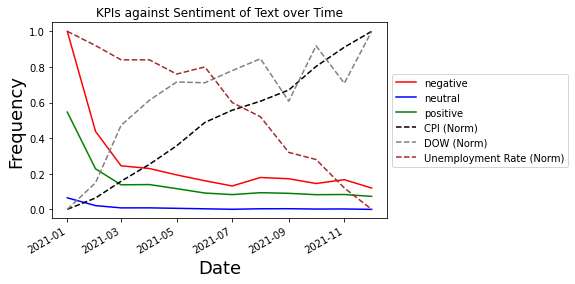

In [0]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

colors = {'negative':'red', 'positive':'green', 'neutral':'blue'}
#cmp1 = cm.get_cmap('Set1', 3)# visualize with the new_inferno colormaps
cmp1 = ListedColormap(['red', 'green', 'blue'])
cmp2 = ListedColormap(['black', 'gray', 'brown'])
fig, ax = plt.subplots()

date_df.groupby('sentiment')['normalized_count'].plot(y=["negative", "neutral", "positive"], legend='True', ax=ax, title="KPIs against Sentiment of Text over Time", color=colors)
date_df.plot(y=["CPI (Norm)", "DOW (Norm)", "Unemployment Rate (Norm)"], ax=ax, colormap=cmp2, linestyle='dashed')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
FS = 18
plt.xlabel('Date', fontsize=FS)
plt.ylabel('Frequency', fontsize=FS)
plt.show()
#plt.savefig('data/plots/kpis_sentiment.png')# Save to data/plots folder

#### Close Spark Session:

In [0]:
spark.stop()